In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torchvision.utils import make_grid

In [11]:
transform = transforms.ToTensor()

In [12]:
train_data = datasets.CIFAR10(root='../01-PyTorch-Basics',download=True,train=True,transform=transform)

Files already downloaded and verified


In [13]:
test_data = datasets.CIFAR10(root='../01-PyTorch-Basics',download=True,train=False,transform=transform)

Files already downloaded and verified


In [14]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../01-PyTorch-Basics
    Split: Train
    StandardTransform
Transform: ToTensor()

In [15]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../01-PyTorch-Basics
    Split: Test
    StandardTransform
Transform: ToTensor()

In [16]:
train_batch_size = 256
test_batch_size = 256
train_loader = DataLoader(train_data,train_batch_size,shuffle=True)
test_loader = DataLoader(test_data,test_batch_size,shuffle=False)

In [17]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    9     7     1     2     3     1     2     0     2     2     1     4
     0     2     1     4     8     0     6     5     7     4     6     2
     9     4     0     0     8     2     8     1     0     4     7     6
     7     6     6     0     8     0     0     4     6     0     7     8
     5     8     8     5     5     3     8     6     5     5     3     1
     0     8     3     1     0     7     5     4     6     2     8     2
     1     2     5     7     7     7     6     4     6     0     7     1
     3     7     2     8     8     8     1     8     8     0     5     7
     7     1     5     0     6     3     8     5     1     2     5     1
     8     8     0     9     7     6     2     5     4     3     4     1
     9     0     1     7     5     9     2     6     2     0     9     9
     4     3     4     5     9     4     6     6     2     8     7     7
     4     5     0     4     4     0     0     8     8     9     2     5
     4     6     3     5     4     3     4  

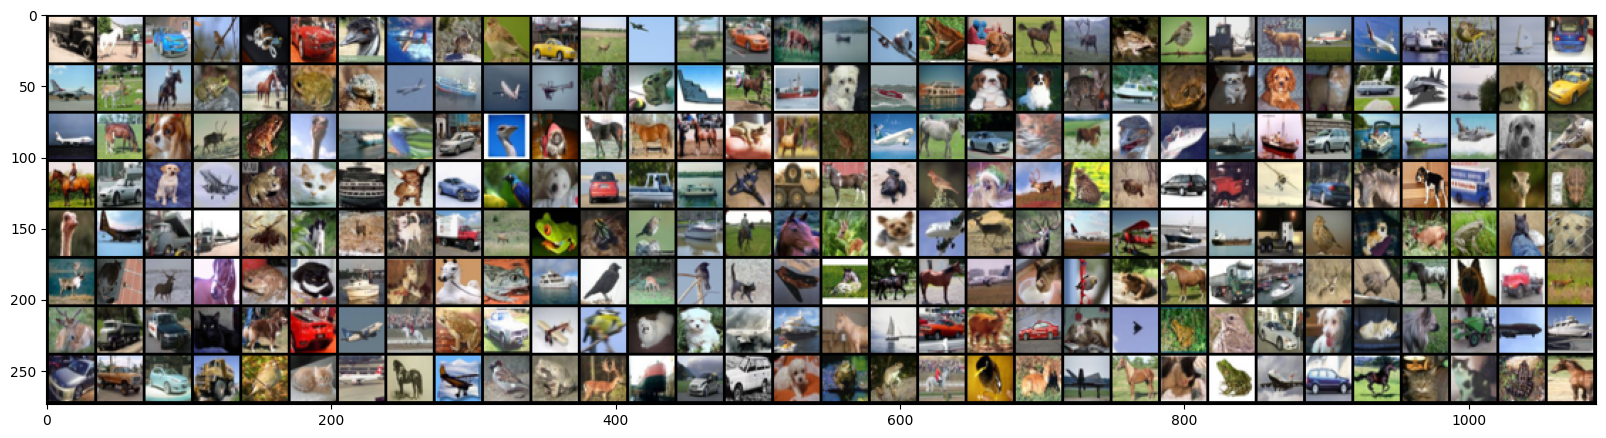

In [18]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=32)  # the default nrow is 8
plt.figure(figsize=(20,12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        #conv->relu->maxpool(2,2) repeat
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,576)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [20]:
device = torch.device("mps")

In [21]:
CNN = CNNModel().to(device)

In [22]:
num_epochs = 20
optimizer = torch.optim.Adam(CNN.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time
train_losses = []
start = time.time()
for epoch in range(num_epochs):
    for img,label in train_loader:
        img,label = img.to(device),label.to(device)
        y_pred = CNN(img)
        loss = criterion(y_pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1)%10==0:
        print(f"epoch : {epoch+1} loss : {loss.item()}")
end = time.time()
print(f"{(end-start)/60} mins")

In [ ]:
plt.plot(train_losses)

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []

CNN.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = CNN(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(f" accuracy : {accuracy_score(all_labels, all_preds)}","\n")
print(classification_report(all_labels, all_preds))


In [ ]:
from sklearn.metrics import confusion_matrix
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = CNN(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1).cpu().numpy(), predicted.view(-1).cpu().numpy())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues_r')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
class VGG6(nn.Module):
    def __init__(self):
        super(VGG6,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,1,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,1,padding=1)
        self.conv5 = nn.Conv2d(128,256,3,1,padding=1)
        self.fc1 = nn.Linear(4*4*64,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.out = nn.Linear(32,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [ ]:
vgg_model = VGG6().to(device)

In [ ]:
import time
from tqdm import tqdm
num_epochs = 100
optimizer = torch.optim.Adam(vgg_model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    vgg_model.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img,label = img.to(device),label.to(device)
        optimizer.zero_grad()
        y_pred = vgg_model(img)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []

vgg_model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img,label = img.to(device),label.to(device)
        pred = vgg_model(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(f" accuracy : {accuracy_score(all_labels, all_preds)}","\n")
print(classification_report(all_labels, all_preds))
